In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data = pd.read_csv('data.csv')

In [13]:
# 1. Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['rsi'] = calculate_rsi(data)

# 2. Average True Range (ATR)
def calculate_atr(data, window=14):
    tr = pd.DataFrame(index=data.index)
    tr['tr0'] = abs(data['high'] - data['low'])
    tr['tr1'] = abs(data['high'] - data['close'].shift())
    tr['tr2'] = abs(data['low'] - data['close'].shift())
    tr['true_range'] = tr.max(axis=1)
    atr = tr['true_range'].rolling(window=window).mean()
    return atr

data['atr'] = calculate_atr(data)

# 3. Moving Average Convergence Divergence (MACD)
def calculate_macd(data, fastperiod=12, slowperiod=26, signalperiod=9):
    exp1 = data['close'].ewm(span=fastperiod, adjust=False).mean()
    exp2 = data['close'].ewm(span=slowperiod, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signalperiod, adjust=False).mean()
    return macd, signal

macd, signal = calculate_macd(data)
data['macd'] = macd
data['macd_signal'] = signal

In [14]:
data.corr(numeric_only = True)

,open,high,low,close,volume,reserve,funding_rates,mvrv,nrpl,nupl,...,RSI,9_ema,21_ema,50_ema,200_ema,Fear_and_Greed_Index,rsi,atr,macd,macd_signal
open,1.000000,0.998384,0.996891,0.996064,-0.112825,0.281327,0.279455,0.617570,0.372467,0.592003,...,-0.034526,0.995336,0.983465,0.947617,0.746385,0.177029,-0.043388,0.784261,0.221608,0.249940
high,0.998384,1.000000,0.996614,0.998242,-0.098912,0.287023,0.287127,0.627728,0.387529,0.599456,...,-0.023179,0.995044,0.982943,0.946636,0.741947,0.179080,-0.034408,0.793903,0.223515,0.251067
low,0.996891,0.996614,1.000000,0.997867,-0.151540,0.273285,0.281331,0.613757,0.385027,0.588494,...,-0.016731,0.992441,0.979741,0.943763,0.747558,0.175281,-0.027315,0.766159,0.226731,0.250364
close,0.996064,0.998242,0.997867,1.000000,-0.123796,0.282456,0.288214,0.628314,0.398791,0.599045,...,-0.007565,0.992933,0.979957,0.943060,0.740470,0.180070,-0.020971,0.782364,0.229900,0.253859
volume,-0.112825,-0.098912,-0.151540,-0.123796,1.000000,-0.222071,0.021872,-0.098896,-0.076559,-0.234323,...,-0.068493,-0.103752,-0.099271,-0.101368,-0.109074,-0.083789,-0.063947,0.083611,-0.032649,-0.000105
reserve,0.281327,0.287023,0.273285,0.282456,-0.222071,1.000000,0.230630,0.592587,0.258569,0.749519,...,0.097742,0.278057,0.270080,0.249410,0.067453,0.373095,0.022178,0.421162,0.111386,0.120128
funding_rates,0.279455,0.287127,0.281331,0.288214,0.021872,0.230630,1.000000,0.669238,0.635275,0.475684,...,0.516376,0.233094,0.175485,0.071996,-0.229208,0.640392,0.441186,0.244389,0.575950,0.527695
mvrv,0.617570,0.627728,0.613757,0.628314,-0.098896,0.592587,0.669238,1.000000,0.690392,0.915949,...,0.437173,0.593199,0.543671,0.431680,0.018488,0.760787,0.321105,0.617511,0.570633,0.590475
nrpl,0.372467,0.387529,0.385027,0.398791,-0.076559,0.258569,0.635275,0.690392,1.000000,0.550118,...,0.562955,0.329968,0.269634,0.167207,-0.109327,0.618047,0.480196,0.285081,0.605055,0.549303
nupl,0.592003,0.599456,0.588494,0.599045,-0.234323,0.749519,0.475684,0.915949,0.550118,1.000000,...,0.377521,0.576923,0.544018,0.466606,0.128093,0.664550,0.262095,0.586347,0.399402,0.420105


In [15]:
# Define features and target variable
features = ['open', 'high', 'low', 'close', 'volume', 'reserve', 'funding_rates',
            'mvrv', 'nrpl', 'nupl', 'stock_to_flow_reversion', 'sth_sopr',
            'RSI','9_ema', '21_ema', '50_ema', '200_ema', 'Fear_and_Greed_Index','rsi','atr','macd','macd_signal']

In [17]:
X = data[features]
y = data['signal'].map({'buy': 0, 'sell': 1, 'none': 2}).astype(int)

In [18]:
# Assuming 'X' is the feature matrix
# Instantiate the imputer with a strategy (e.g., 'mean', 'median', 'most_frequent')
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your data and transform it
X_imputed = imputer.fit_transform(X)

In [19]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [20]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [22]:
# Train Random Forest Classifier with class weights
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight={i: weight for i, weight in enumerate(class_weights)}, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 4.2988505747126435,
                                     1: 3.7213930348258706,
                                     2: 0.4002140181915463},
                       random_state=42)

In [23]:
# Evaluate model
y_pred = rf_classifier.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.67      0.11      0.18        19
           2       0.80      0.99      0.89       148

    accuracy                           0.80       187
   macro avg       0.82      0.38      0.39       187
weighted avg       0.81      0.80      0.73       187

Confusion Matrix:
[[  1   0  19]
 [  0   2  17]
 [  0   1 147]]


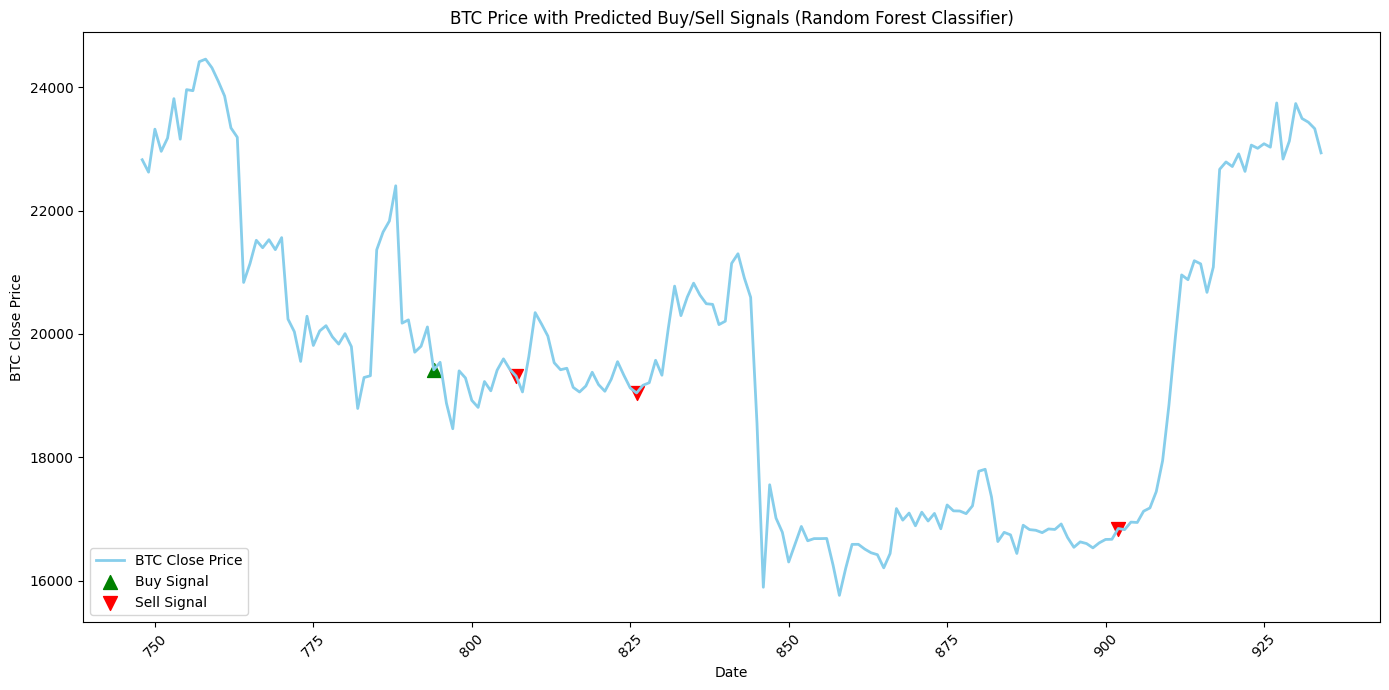

In [24]:
import matplotlib.pyplot as plt

# Plot BTC close price for the test set
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(X_test):], data['close'][-len(X_test):], label='BTC Close Price', color='skyblue', linewidth=2)

# Plot buy signals for the test set
buy_indices = data.index[-len(X_test):][y_pred == 0]  # Assuming 0 represents 'buy' in your predictions
buy_signals = data.loc[buy_indices]
plt.scatter(buy_indices, buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)

# Plot sell signals for the test set
sell_indices = data.index[-len(X_test):][y_pred == 1]  # Assuming 1 represents 'sell' in your predictions
sell_signals = data.loc[sell_indices]
plt.scatter(sell_indices, sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals (Random Forest Classifier)')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()